Splitting datasets: 100%|██████████████████████████████████████████████████████████████| 15/15 [00:20<00:00,  1.39s/it]



Dataset split summary:
Agriculture: Train=640, Test=160
Airport: Train=640, Test=160
Beach: Train=640, Test=160
City: Train=640, Test=160
Desert: Train=640, Test=160
Forest: Train=640, Test=160
Grassland: Train=640, Test=160
Highway: Train=640, Test=160
Lake: Train=640, Test=160
Mountain: Train=640, Test=160
Parking: Train=640, Test=160
Port: Train=640, Test=160
Railway: Train=640, Test=160
Residential: Train=640, Test=160
River: Train=640, Test=160

Starting training...


Epoch 1/10, Loss: 1.1805, Acc: 0.6908


Epoch 2/10, Loss: 0.7040, Acc: 0.7918


Epoch 3/10, Loss: 0.6232, Acc: 0.8052


Epoch 4/10, Loss: 0.5835, Acc: 0.8207


Epoch 5/10, Loss: 0.5624, Acc: 0.8223


Epoch 6/10, Loss: 0.5459, Acc: 0.8255


Epoch 7/10, Loss: 0.5211, Acc: 0.8354


Epoch 8/10, Loss: 0.5200, Acc: 0.8393


Epoch 9/10, Loss: 0.5063, Acc: 0.8443


Epoch 10/10, Loss: 0.5075, Acc: 0.8396



Model Evaluation Metrics:
Precision: 0.8645
Recall: 0.8621
F1 Score: 0.8604

Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.868     0.944     0.904       160
     Airport      0.794     0.894     0.841       160
       Beach      0.863     0.906     0.884       160
        City      0.919     0.850     0.883       160
      Desert      0.876     0.925     0.900       160
      Forest      0.935     0.894     0.914       160
   Grassland      0.863     0.944     0.901       160
     Highway      0.788     0.950     0.861       160
        Lake      0.748     0.613     0.674       160
    Mountain      0.874     0.950     0.910       160
     Parking      0.895     0.856     0.875       160
        Port      0.942     0.713     0.811       160
     Railway      0.854     0.844     0.849       160
 Residential      0.959     0.875     0.915       160
       River      0.790     0.775     0.782       160

    accuracy                     

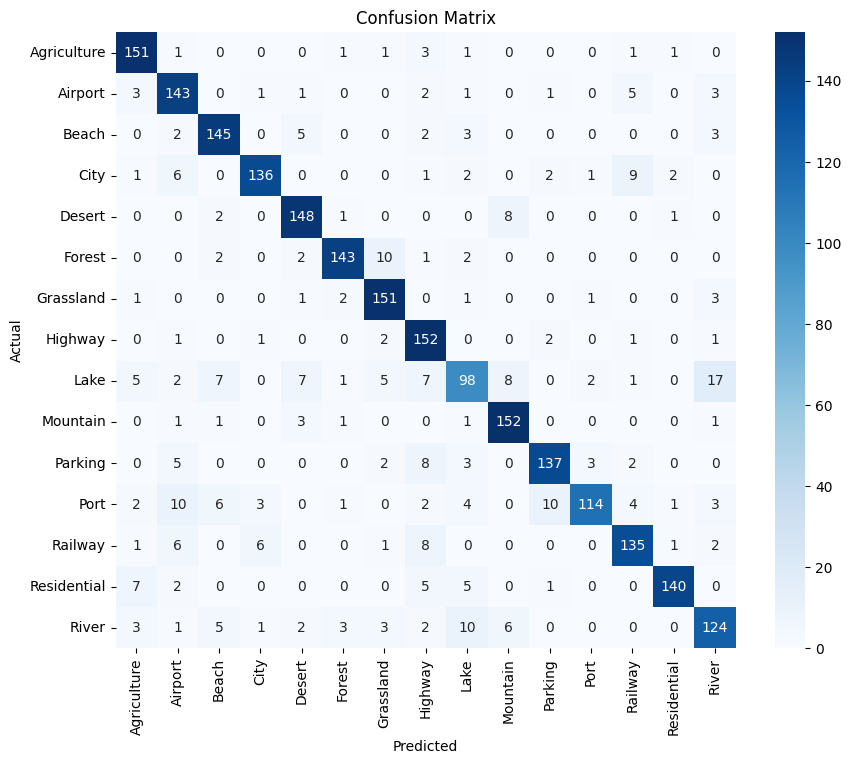


Model saved to landscape_classifier.pth


In [11]:
#EfficientNet-B0
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
config = {
    "data_dir": "Landscapes",
    "selected_classes": [
        "Agriculture", "Airport", "Beach", "City", "Desert",
        "Forest", "Grassland", "Highway", "Lake", "Mountain",
        "Parking", "Port", "Railway", "Residential", "River"
        ],
    "train_dir": "train_data",
    "test_dir": "test_data",
    "batch_size": 32,
    "num_epochs": 10,
    "learning_rate": 0.001,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

def prepare_datasets():
    """Create train/test splits with 80% training and 20% test data per class."""
    # Clean existing directories
    for d in [config["train_dir"], config["test_dir"]]:
        if os.path.exists(d):
            shutil.rmtree(d)
        os.makedirs(d)

    for cls in tqdm(config["selected_classes"], desc="Splitting datasets"):
        # Create class directories
        os.makedirs(os.path.join(config["train_dir"], cls), exist_ok=True)
        os.makedirs(os.path.join(config["test_dir"], cls), exist_ok=True)

        src_dir = os.path.join(config["data_dir"], cls)
        all_images = [f for f in os.listdir(src_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if not all_images:
            raise FileNotFoundError(f"No images found in {src_dir}")

        np.random.shuffle(all_images)
        split_idx = int(0.8 * len(all_images))

        for img in all_images[:split_idx]:
            src = os.path.join(src_dir, img)
            dst = os.path.join(config["train_dir"], cls, img)
            shutil.copy2(src, dst)

        for img in all_images[split_idx:]:
            src = os.path.join(src_dir, img)
            dst = os.path.join(config["test_dir"], cls, img)
            shutil.copy2(src, dst)

    print("\nDataset split summary:")
    for cls in config["selected_classes"]:
        train_count = len(os.listdir(os.path.join(config["train_dir"], cls)))
        test_count = len(os.listdir(os.path.join(config["test_dir"], cls)))
        print(f"{cls}: Train={train_count}, Test={test_count}")

def get_dataloaders():
    """Create augmented dataloaders"""
    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(config["train_dir"], transform=train_transform)
    test_dataset = datasets.ImageFolder(config["test_dir"], transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    return train_loader, test_loader, train_dataset.classes

def initialize_model():
    """EfficientNet-B0 (smallest, fastest)"""
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[-1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(config["selected_classes"]))
    model = model.to(config["device"])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[-1].parameters(), lr=config["learning_rate"])
    return model, criterion, optimizer

def train_model(model, criterion, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(config["device"]), labels.to(config["device"])

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("\n" + "="*50)
    print(f"Model Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("="*50 + "\n")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names,digits=3))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

if __name__ == "__main__":
    prepare_datasets()

    train_loader, test_loader, class_names = get_dataloaders()

    model, criterion, optimizer = initialize_model()

    print("\nStarting training...")
    for epoch in range(config["num_epochs"]):
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader)
        print(f"Epoch {epoch + 1}/{config['num_epochs']}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

    evaluate_model(model, test_loader, class_names)

    torch.save(model.state_dict(), "landscape_classifier.pth")
    print("\nModel saved to landscape_classifier.pth")

Splitting datasets: 100%|██████████████████████████████████████████████████████████████| 15/15 [00:19<00:00,  1.33s/it]



Dataset split summary:
Agriculture: Train=640, Test=160
Airport: Train=640, Test=160
Beach: Train=640, Test=160
City: Train=640, Test=160
Desert: Train=640, Test=160
Forest: Train=640, Test=160
Grassland: Train=640, Test=160
Highway: Train=640, Test=160
Lake: Train=640, Test=160
Mountain: Train=640, Test=160
Parking: Train=640, Test=160
Port: Train=640, Test=160
Railway: Train=640, Test=160
Residential: Train=640, Test=160
River: Train=640, Test=160

Starting training...


Epoch 1/10, Loss: 1.0754, Acc: 0.7304


Epoch 2/10, Loss: 0.5829, Acc: 0.8330


Epoch 3/10, Loss: 0.5000, Acc: 0.8474


Epoch 4/10, Loss: 0.4520, Acc: 0.8635


Epoch 5/10, Loss: 0.4375, Acc: 0.8620


Epoch 6/10, Loss: 0.4146, Acc: 0.8684


Epoch 7/10, Loss: 0.3941, Acc: 0.8749


Epoch 8/10, Loss: 0.3786, Acc: 0.8803


Epoch 9/10, Loss: 0.3851, Acc: 0.8768


Epoch 10/10, Loss: 0.3738, Acc: 0.8785



Model Evaluation Metrics:
Precision: 0.9033
Recall: 0.9021
F1 Score: 0.9014

Classification Report:
              precision    recall  f1-score   support

 Agriculture      0.921     0.950     0.935       160
     Airport      0.841     0.894     0.867       160
       Beach      0.932     0.850     0.889       160
        City      0.881     0.875     0.878       160
      Desert      0.943     0.931     0.937       160
      Forest      0.981     0.950     0.965       160
   Grassland      0.911     0.956     0.933       160
     Highway      0.868     0.944     0.904       160
        Lake      0.824     0.700     0.757       160
    Mountain      0.905     0.950     0.927       160
     Parking      0.912     0.975     0.943       160
        Port      0.963     0.819     0.885       160
     Railway      0.825     0.912     0.866       160
 Residential      0.987     0.963     0.975       160
       River      0.857     0.863     0.860       160

    accuracy                     

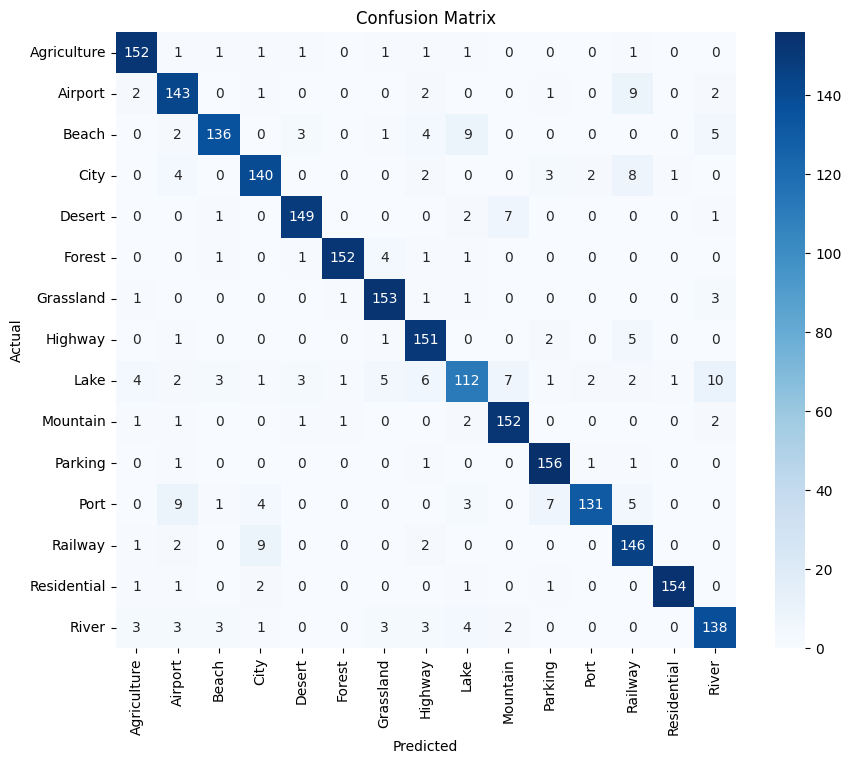


Model saved to landscape_classifier.pth


In [30]:


#EfficientNet-B0
import os
import shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
config = {
    "data_dir": "Landscapes",
    "selected_classes": [
        "Agriculture", "Airport", "Beach", "City", "Desert",
        "Forest", "Grassland", "Highway", "Lake", "Mountain",
        "Parking", "Port", "Railway", "Residential", "River"
        ],
    "train_dir": "train_data",
    "test_dir": "test_data",
    "batch_size": 32,
    "num_epochs": 10,
    "learning_rate": 0.001,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

def prepare_datasets():
    """Create train/test splits with 80% training and 20% test data per class."""
    # Clean existing directories
    for d in [config["train_dir"], config["test_dir"]]:
        if os.path.exists(d):
            shutil.rmtree(d)
        os.makedirs(d)

    for cls in tqdm(config["selected_classes"], desc="Splitting datasets"):
        # Create class directories
        os.makedirs(os.path.join(config["train_dir"], cls), exist_ok=True)
        os.makedirs(os.path.join(config["test_dir"], cls), exist_ok=True)

        src_dir = os.path.join(config["data_dir"], cls)
        all_images = [f for f in os.listdir(src_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if not all_images:
            raise FileNotFoundError(f"No images found in {src_dir}")

        np.random.shuffle(all_images)
        split_idx = int(0.8 * len(all_images))

        for img in all_images[:split_idx]:
            src = os.path.join(src_dir, img)
            dst = os.path.join(config["train_dir"], cls, img)
            shutil.copy2(src, dst)

        for img in all_images[split_idx:]:
            src = os.path.join(src_dir, img)
            dst = os.path.join(config["test_dir"], cls, img)
            shutil.copy2(src, dst)

    print("\nDataset split summary:")
    for cls in config["selected_classes"]:
        train_count = len(os.listdir(os.path.join(config["train_dir"], cls)))
        test_count = len(os.listdir(os.path.join(config["test_dir"], cls)))
        print(f"{cls}: Train={train_count}, Test={test_count}")

def get_dataloaders():
    """Create augmented dataloaders"""
    # train_transform = transforms.Compose([
    #     transforms.Resize(256),
    #     transforms.RandomResizedCrop(224),
    #     transforms.RandomHorizontalFlip(),
    #     transforms.ToTensor(),
    #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    # ])
    train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(config["train_dir"], transform=train_transform)
    test_dataset = datasets.ImageFolder(config["test_dir"], transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

    return train_loader, test_loader, train_dataset.classes

def initialize_model():
    """EfficientNet-B0 (smallest, fastest)"""
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[-1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, len(config["selected_classes"]))
    model = model.to(config["device"])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[-1].parameters(), lr=config["learning_rate"])
    return model, criterion, optimizer

def train_model(model, criterion, optimizer, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
        inputs, labels = inputs.to(config["device"]), labels.to(config["device"])

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(config["device"]), labels.to(config["device"])
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    print("\n" + "="*50)
    print(f"Model Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("="*50 + "\n")
    
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names,digits=3))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

if __name__ == "__main__":
    prepare_datasets()

    train_loader, test_loader, class_names = get_dataloaders()

    model, criterion, optimizer = initialize_model()

    print("\nStarting training...")
    for epoch in range(config["num_epochs"]):
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader)
        print(f"Epoch {epoch + 1}/{config['num_epochs']}, Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

    evaluate_model(model, test_loader, class_names)

    torch.save(model.state_dict(), "landscape_classifier.pth")
    print("\nModel saved to landscape_classifier.pth")